# 3D Spectra

From the previous two tutorials you should understand how:

1. How to convert your GCM input to `PICASO`'s required `xarray`
2. How to post-process output to append to your GCM output

Here you will learn:

1. How to run a 3D spectrum
2. How to analyze the resulting output

**Citation: [Adams et al. 2022 "Spatially Resolved Modeling of Optical Albedos for a Sample of Six Hot Jupiters" ApJ](https://ui.adsabs.harvard.edu/abs/2022ApJ...926..157A/abstract)**

In [1]:
import pandas as pd
import numpy as np

from picaso import justdoit as jdi
from picaso import justplotit as jpi
jpi.output_notebook()

Loading BokehJS ...

## Run Cloud-Free 3D Spectra

By now you should have completed all the 3D inputs notebooks. This will just take you through completing the last step or running 3D spectra and analyzing your output.

Note most of the framework here follows the regular PICASO framework. If you need a refresher on the general workflow, please see earlier tutorials.

In [2]:
opacity = jdi.opannection(wave_range=[1.1,1.7])

In [3]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True)
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_gangle=10, num_tangle=10)
case_3d.atmosphere_3d(gcm_out,regrid=True,plot=False,verbose=False)
case_3d.chemeq_3d(n_cpu=5) #parallelize chemistry run
case_3d.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'),
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun'))

/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


### Predicting Compute Runtimes for 3D Calculations

The speed of the code will be nearly directly proportional to the number of gangles and tangles as on radiative transfer calculation has to be computed for each facet of the "disco ball".

In [4]:
out3d = case_3d.spectrum(opacity,calculation='thermal',dimension='3d',full_output=True)

## Analyze 3D Spectra

In [5]:
#same old same old
wno,fpfs = jdi.mean_regrid(out3d['wavenumber'],out3d['fpfs_thermal'],R=100)
jpi.show(jpi.spectrum(wno, fpfs*1e6, plot_width=500,y_axis_type='log'))

In [6]:
jpi.show(jpi.flux_at_top(out3d ,
                     pressures = [5,1,0.8],
                     ng=0,nt=0,R=100,
                     plot_height=500, plot_width=500))#note the addition of ng and nt

### 3D Map of Flux

We can use the same plot as we used for reflected light. In 3D this plot is quite a bit more interesting since we can see variations across the disk from out input file.

Note below I specify thermal. The default is reflected, I just chose this as an example.

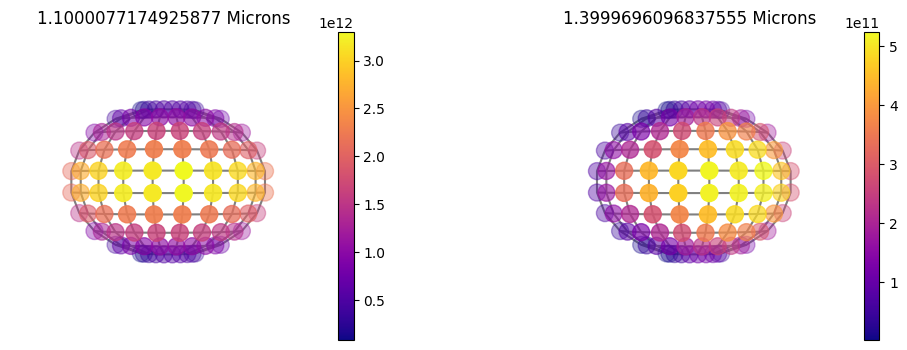

In [7]:
jpi.disco(out3d['full_output'] ,wavelength=[1.1, 1.4], calculation='thermal')

### 3D Map of Gas Opacity Sources

In addition to disco there is a general map function that can plot anything in `picaso`’s full output dict. Below is an example of the `taugas` where we must specify both a pressure and wavelength to plot the map

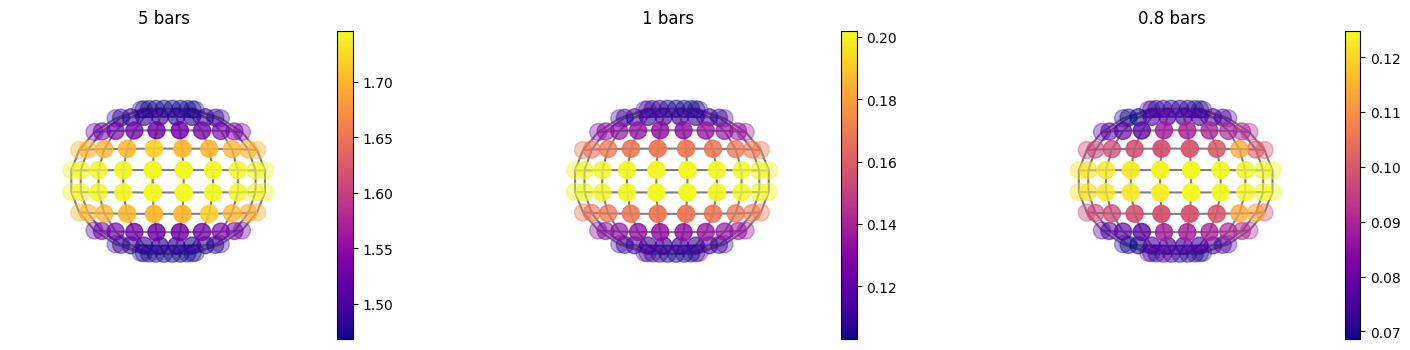

In [8]:
#Since Taugas is [nlayer, nwave, nlong, nlat] we can specify a list of pressures and a SINGLE wavelength.
jpi.map(out3d['full_output'],plot='taugas',pressure=[5,1,0.8],wavelength=0.5)

## Run Cloudy 3D Spectra

If you have not already, please consult the tutorial on post-processing cloud inputs. Below, we will use `virga` to post-process clouds on our example GCM input.

verbose=True;regrid=True; Regridding 3D output to ngangle=10, ntangle=10, with phase=0.


/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/pic313/lib/python3.13/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


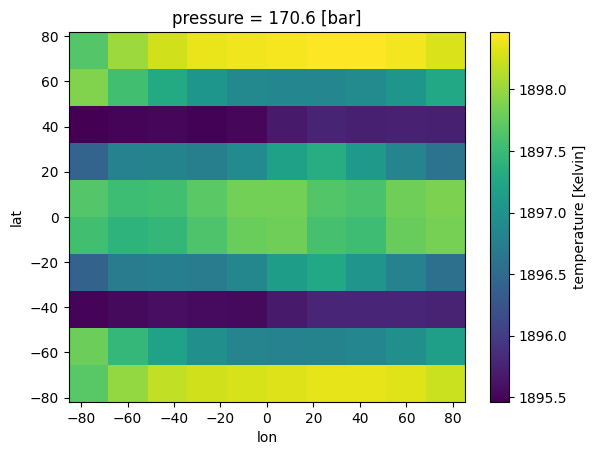

In [9]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True,add_kz=True)
case_3d = jdi.inputs()
case_3d.phase_angle(0, num_tangle=10, num_gangle=10)
case_3d.atmosphere_3d(gcm_out, regrid=True)
case_3d.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'),
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun'))
case_3d.chemeq_3d(n_cpu=5)
mieff_directory = '/data/virga/'
clds = case_3d.virga_3d(['MnS'], mieff_directory,fsed=1,kz_min=1e10,
                        verbose=False,n_cpu=3, full_output=True
                       )

In [10]:
out3d_cld = case_3d.spectrum(opacity,
                             calculation='thermal',dimension='3d',full_output=True)

### 3D $\tau$~1 Pressure-Level Map

Here we can break down a full map of the molecular, cloud and rayleigh opacity. Whereas in map we had to specify a specific pressure and wavelength, here we can specify an optical depth and it will produce a map of what pressure level corresponds to that optical depth. We tend to see photons that originate from tau=1. Therefore, it is interesting to plot a tau=1 map so we can see if we are seeing different pressure levels at different locations across the disk.

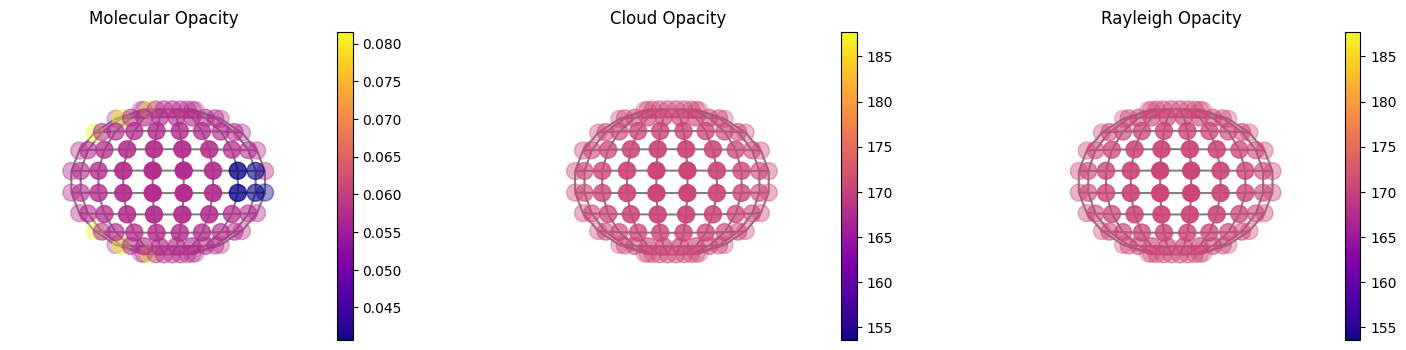

In [11]:
#NOTE, we haven't run clouds and are not at short wavelengths,
#so the cloud and rayleigh opacity will not be too interesting
jpi.taumap(out3d_cld['full_output'], wavelength=1.4, at_tau=1)